# Introduction

*Goal*: To explore different modeling choices that interpret Colorado's constitutional language of political competitiveness.

*Motivation*: “Thereafter, the commission shall, to the extent possible, maximize the number of politically competitive districts… ‘competitive’ means having a reasonable potential for the party affiliation of the district’s representative to change at least once between federal decennial censuses. 

Competitiveness may be measured by factors such as a proposed district’s past election results, a proposed district’s political party registration data, and evidence-based analyses of proposed districts.” - [Congressional Language (Section 44.3)](https://redistricting.colorado.gov/content/redistricting-laws) 

# Background

# Political Competitiveness

What is political competitiveness? 

# Data Selection  

*Decision Point*: Is the data sufficient for the analyses I want to run?

The Colorado case study utilizes a processed shapefile of [2018 precinct-level election results](https://github.com/mggg-states/CO-shapefiles). More details on MGGG’s Colorado data source and process can be found [here](https://github.com/mggg-states/CO-shapefiles). The shapefile contains one federal election (U.S. House race) and four state-level and, as well as  racial demographic data for the population and voting age population of the precinct.

*Limitations*: Due to raw data quality initially supplied to MGGG from the Colorado State Demographer's Office and the need for extended processing, 81% (n= 2555) of the precincts in the final shapefile do have have a state-wide 10-digit unique precinct ID. This made joining MGGG’s shapefile with other precinct-level data tricky since only 19% of the IDs matched upon a simple merge. Higher-level unique IDs, such as Voting District, are available, but would aggregate up and lose the precinct distinctions. 

Additionally, Colorado's precinct boundaries change annually due to shifting population totals, so while Congressional district boundaries remained the same from 2012-2022, there have been slight shifts of precinct lines over the years. There is currently a lack of publically available, clean data that keeps track of precinct changes over time and election results tracked across the years.

Therefore only 2018 election data is available and attached to the preprocessed MGGG shapefile use in this EDA file.

*Notes*: Our team cleaned and merged [archival election data](https://www.sos.state.co.us/pubs/elections/Results/Archives.html) from the Colorado Secretary of State, and built a precinct-level panel data of all federal election results from 2004 - 2020. This data is available in our [Colorado/Data folder](https://github.com/uwescience/dssg2021-redistricting/tree/main/Colorado/Data) and may be of use for users if they choose to interpret Colorado's language of competitiveness as "measured by factors such as a proposed district’s past election results". There are non-trivial challenges associated with merging this panel data to cleaned, preprocessed shapefiles appropriate for GerryChain.


In [1]:
import os
import sys
import random
import pandas as pd
import geopandas as gpd
from gerrychain import Graph

from functools import partial
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_theme(style="whitegrid")

from gerrychain import (
    Election,
    Graph,
    MarkovChain,
    Partition,
    accept, 
    constraints,
    updaters,
)

from gerrychain.proposals import recom, propose_random_flip
from gerrychain.metrics import efficiency_gap, mean_median, polsby_popper, wasted_votes
from gerrychain.updaters import cut_edges, county_splits
from gerrychain.tree import recursive_tree_part, bipartition_tree_random

sys.path.insert(0, os.getenv("REDISTRICTING_HOME"))
import utility_functions as uf

try:
    os.chdir(os.path.join(os.getenv("REDISTRICTING_HOME", default=""),
                          "Colorado"))
except OSError:
    os.mkdir(os.path.join(os.getenv("REDISTRICTING_HOME", default=""),
                          "Colorado"))
    os.chdir(os.path.join(os.getenv("REDISTRICTING_HOME", default=""),
                          "Colorado"))

In [2]:
graph_mggg = Graph.from_json("Data/co_precincts.json")
df_mggg = gpd.read_file("Data/co_precincts.shp")

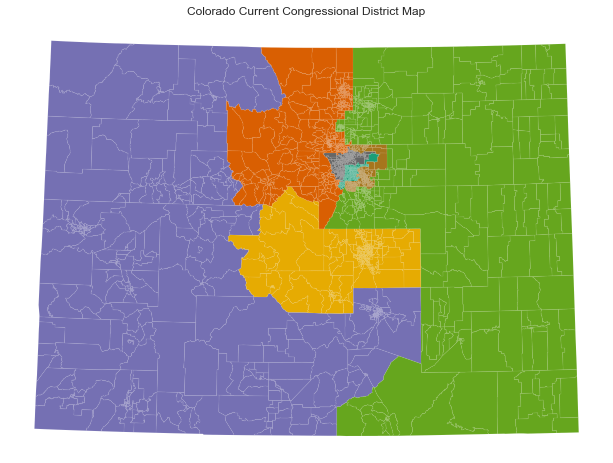

In [57]:
#See current CO Congressional district map
uf.plot_district_map(df_mggg, 
                     df_mggg['CD116FP'].to_dict(), 
                     title="Colorado Current Congressional District Map", 
                     map_colors="Dark2")

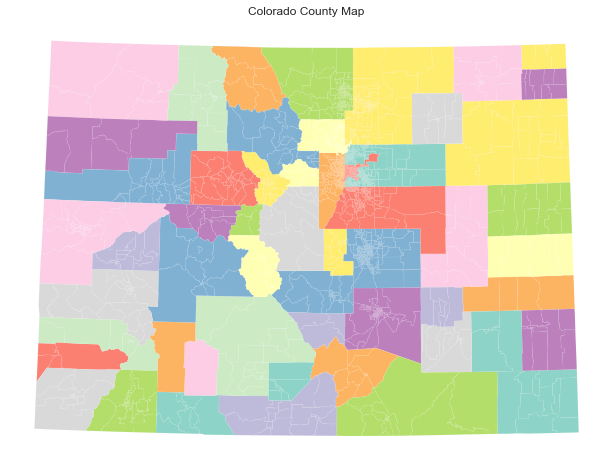

In [58]:
uf.plot_district_map(df_mggg, 
                     df_mggg['COUNTYFP'].to_dict(), 
                     title="Colorado County Map", 
                     map_colors="Set3")

Visualize Colorado dual graph


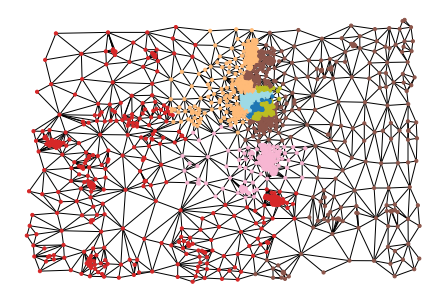

In [5]:
print("Visualize Colorado dual graph")

nx.draw(graph_mggg,pos = {node:(graph_mggg.nodes[node]["C_X"],graph_mggg.nodes[node]["C_Y"]) 
                     for node in graph_mggg.nodes()},node_color=[graph_mggg.nodes[node]["CD116FP"] 
                                                            for node in graph_mggg.nodes()],node_size=10,cmap='tab20')

# Metric Selection

*Decision Point*: Which metrics are most appriopriate for my analysis?

In [6]:
#POC Voting age population for Colorado in 2018

print((df_mggg["HVAP"].sum())/(df_mggg["VAP"].sum()))
print((df_mggg["BVAP"].sum())/(df_mggg["VAP"].sum()))
print((df_mggg["ASIANVAP"].sum())/(df_mggg["VAP"].sum()))

df_mggg["POC_VAP"] = (df_mggg["HVAP"] + df_mggg["BVAP"] + df_mggg["AMINVAP"] + df_mggg["ASIANVAP"] 
 + df_mggg["NHPIVAP"] + df_mggg["OTHERVAP"] + df_mggg["OTHERVAP"])

df_mggg["POC_VAP_PCT"] = df_mggg["POC_VAP"]/df_mggg["VAP"]

print(df_mggg["WVAP"].sum()/df_mggg["VAP"].sum()) 
print("White Voting Age Population in Colorado")
#0.7388 White VAP across the state

print(df_mggg["POC_VAP"].sum() / df_mggg["VAP"].sum())
print("POC Voting Age Population in Colorado")
#0.246 POC VAP across the state

0.1743624475281691
0.036148225689366764
0.026797456102513387
0.7388031162218177
White Voting Age Population in Colorado
0.24619388538784442
POC Voting Age Population in Colorado


Text(0.5, 1.0, 'Precinct Percentage of POC Voting Age Population')

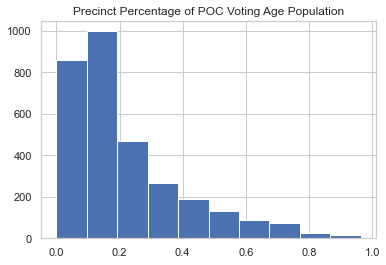

In [82]:
plt.hist(df_mggg['POC_VAP_PCT'])
plt.title("Precinct Percentage of POC Voting Age Population")

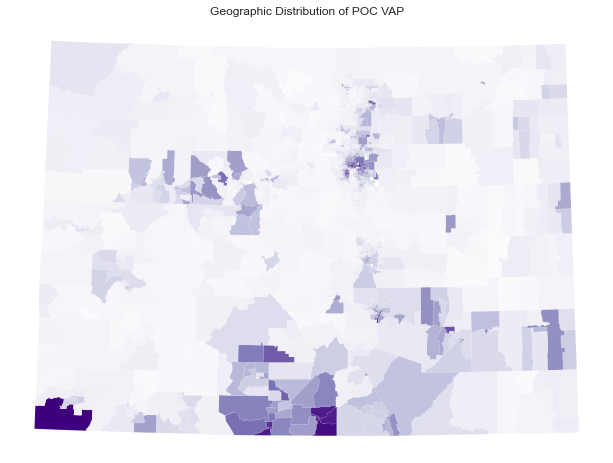

In [60]:
uf.plot_district_map(df_mggg, 
                     df_mggg['POC_VAP_PCT'].to_dict(), 
                     title="Geographic Distribution of POC VAP",
                     map_colors="Purples")

for node in graph_mggg.nodes():
    graph_mggg.nodes[node]["POC_VAP"] = (graph_mggg.nodes[node]["HVAP"] + graph_mggg.nodes[node]["BVAP"] 
                                    + graph_mggg.nodes[node]["AMINVAP"] + graph_mggg.nodes[node]["ASIANVAP"] 
                                    + graph_mggg.nodes[node]["NHPIVAP"] + graph_mggg.nodes[node]["OTHERVAP"] 
                                    + graph_mggg.nodes[node]["OTHERVAP"])
    graph_mggg.nodes[node]["nPOC_VAP"] = graph_mggg.nodes[node]["VAP"] - graph_mggg.nodes[node]["POC_VAP"]

In [8]:
state_abbr="CO"
housen="CON"
num_districts=7
pop_col="TOTPOP"
num_elections= 7

def num_splits(partition, df=df_mggg):
    df["current"] = df.index.map(partition.assignment)
    return sum(df.groupby('COUNTYFP')['current'].nunique() > 1)

updater = {
    "population": updaters.Tally("TOTPOP", alias="population"), 
    "cut_edges": cut_edges,
    "PP":polsby_popper,
    "count_splits": num_splits
            }

election_names=[
    "POC_VAP", 
    "USH18", 
    "GOV18", 
    "AG18", 
    "SOS18", 
    "TRE18", 
    "REG18", 
    ]

election_columns=[
    ["POC_VAP", "nPOC_VAP"], 
    ["USH18D", "USH18R"], 
    ["GOV18D", "GOV18R"], 
    ["AG18D", "AG18R"], 
    ["SOS18D", "SOS18R"], 
    ["TRE18D", "TRE18R"], 
    ["REG18D", "REG18R"]
    ]

elections = [
    Election(
        election_names[i], 
        {"First": election_columns[i][0], "Second": election_columns[i][1]},
    )
    for i in range(num_elections)
]

election_updaters = {election.name: election for election in elections}
updater.update(election_updaters)

totpop = df_mggg.TOTPOP.sum()

In [9]:
plan_2012 = Partition(graph_mggg,
                      df_mggg["CD116FP"],
                      updater)

plan_2012_stats = uf.export_election_metrics_per_partition(plan_2012)

#Tidy df 
plan_2012_stats.iloc[0, 1] = float('NaN') 
plan_2012_stats.iloc[0, 2] = float('NaN') 
plan_2012_stats = plan_2012_stats.rename({'wins':'dem_wins'}, axis=1)

plan_2012_names = plan_2012_stats.index.values
plan_2012_comp=[]
for n in range(7):
    plan_2012_comp.append(sum([.45<x<.55 for x in plan_2012[plan_2012_names[n]].percents('First')]))

plan_2012_stats['comp_dist'] = np.array(plan_2012_comp)
plan_2012_stats.iloc[0, 4] = float('NaN') 

plan_2012_stats

,percent,efficiency_gap,mean_median,dem_wins,comp_dist
POC_VAP,"(0.36141401056272865, 0.30885724837843453, 0.2...",NaN,NaN,0,NaN
USH18,"(0.7620680507658154, 0.5579114187509663, 0.393...",-0.021520,0.007573,4,1.0
GOV18,"(0.7550250594242573, 0.5617245527618341, 0.397...",-0.017109,0.012444,4,1.0
AG18,"(0.7370862552790284, 0.5334206800363475, 0.378...",0.025778,0.005783,4,2.0
SOS18,"(0.7337444396712997, 0.5506415939806384, 0.398...",0.010094,0.014931,4,1.0
TRE18,"(0.732847922200158, 0.547696059594734, 0.39421...",0.017570,0.015233,4,2.0
REG18,"(0.7518072716104798, 0.5581663902003318, 0.389...",-0.001952,0.016462,4,1.0


In [10]:
print("The 2012 enacted plan contained", plan_2012["count_splits"], "county splits out of 64 total counties.")
print("In other words,", ((plan_2012["count_splits"]/64)*100), "% of counties were split in the 2012 enacted plan.")


The 2012 enacted plan contained 7 county splits out of 64 total counties.
In other words, 10.9375 % of counties were split in the 2012 enacted plan.


# Seed Plan Selection

*Decision Point*: Will you use an existing/enacted map or a random one?

*Context*: Need to decide the appropriate starting plan to begin the ensemble. One option is the 2012 enacted plan -- however it has been claimed to be a Democrat gerrymandered map by Republicans. 

Another option is to generate a collection of neutral seed plans made up of 7 districts organized by Democratic share of votes to indicate competitiveness

*Process*: I generated 10 seed plans and built a dataframe of their Democrat vote totals and Democrat seat wins using the 2018 US House election data 
    
*Decision*: 

In [11]:
seeds_county=[]
seeds_comp=[]

#Running multiple seeds to note comp districts and county splits of starting plans
for n in range(100):
    plan_seed = recursive_tree_part(graph_mggg, #graph object
                                    range(num_districts), #How many districts
                                    totpop/num_districts, #population target
                                    "TOTPOP", #population column, variable name
                                    .01, #epsilon value
                                    1)
    
    partition_seed = Partition(graph_mggg,
                           plan_seed, 
                           updater)
    seeds_county.append(partition_seed["count_splits"])
    seeds_comp.append(sum([.45<x<.55 for x in partition_seed['USH18'].percents('First')]))

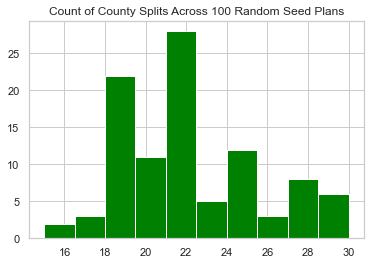

The min count of county splits is 15
The max count of county splits is 30


In [86]:
plt.hist(seeds_county, color="green")
plt.locator_params(axis="both", integer=True, tight=True)
plt.title("Count of County Splits Across 100 Random Seed Plans")
plt.show()

print("The min count of county splits is", min(seeds_county))
print("The max count of county splits is", max(seeds_county))

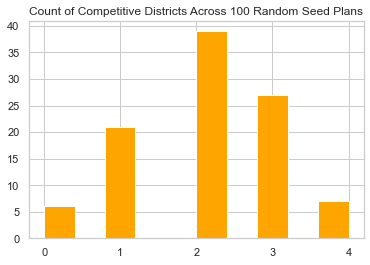

The min count of competitive districts is 0
The max count of competitive districts is 4


In [87]:
plt.hist(seeds_comp, color="orange")
plt.locator_params(axis="both", integer=True, tight=True)
plt.title("Count of Competitive Districts Across 100 Random Seed Plans")
plt.show()

print("The min count of competitive districts is", min(seeds_comp))
print("The max count of competitive districts is", max(seeds_comp))

# Proposal Selection

*Decision Point*: Is Flip Step or ReCombination more appropriate?



In [14]:
plan_set_seed = recursive_tree_part(graph_mggg, #graph object
                                range(num_districts), #How many districts
                                totpop/num_districts, #population target
                                "TOTPOP", #population column, variable name
                                .01, #epsilon value
                                1)

partition_set_seed = Partition(graph_mggg,
                           plan_set_seed, 
                           updater)

In [17]:
ideal_population = sum(partition_set_seed["population"].values()) / len(partition_set_seed)

popbound = constraints.within_percent_of_ideal_population(partition_set_seed, 0.01)

compactness_bound = constraints.UpperBound(
    lambda p: len(p["cut_edges"]), 1.5 * len(partition_set_seed["cut_edges"])
)

In [18]:
recom_proposal = partial(
    recom,
    pop_col="TOTPOP",
    pop_target=ideal_population,
    epsilon=0.01,
    node_repeats=1,
    method=bipartition_tree_random
)

In [38]:
steps_num = 1000

chain_2012_flip = MarkovChain(
    proposal=propose_random_flip,
    constraints=[
        popbound,
        compactness_bound
    ],
    accept=accept.always_accept, 
    initial_state=plan_2012,
    total_steps=steps_num*10
)

chain_2012_recom = MarkovChain(
    proposal=recom_proposal,
    constraints=[
        popbound,
        compactness_bound
    ],
    accept=accept.always_accept, 
    initial_state=plan_2012,
    total_steps=steps_num
)

chain_seed_flip = MarkovChain(
    proposal=propose_random_flip,
    constraints=[
        popbound,
        compactness_bound
    ],
    accept=accept.always_accept, 
    initial_state=partition_set_seed,
    total_steps=steps_num*10
)

chain_seed_recom = MarkovChain(
    proposal=recom_proposal,
    constraints=[
        popbound,
        compactness_bound
    ],
    accept=accept.always_accept, 
    initial_state=partition_set_seed,
    total_steps=steps_num
)


In [39]:
chain_dict = {
              'flip_2012': chain_2012_flip,
              'recom_2012': chain_2012_recom,
              'flip_seed': chain_seed_flip,
              'recom_seed': chain_seed_recom,
             }

per_chain = {chain_name: {} for chain_name in chain_dict.keys()}

for name, chain in chain_dict.items():
    print(name)
    count_county=[]
    count_comp=[]
    for part in chain:
        count_county.append(part["count_splits"])
        count_comp.append(sum([.45<x<.55 for x in part['USH18'].percents('First')]))

    per_chain[name]['county_splits'] = np.array(count_county)
    per_chain[name]['comp_dist'] = np.array(count_comp)


flip_2012
recom_2012
flip_seed
recom_seed


In [40]:
pc_keys = list(per_chain.keys())

df_county_split = pd.DataFrame(columns=pc_keys)
df_comp_dist = pd.DataFrame(columns=pc_keys)

for n in range(4):
    df_county_split[pc_keys[n]] = pd.Series(per_chain[pc_keys[n]]["county_splits"])
    df_comp_dist[pc_keys[n]] = pd.Series(per_chain[pc_keys[n]]["comp_dist"])

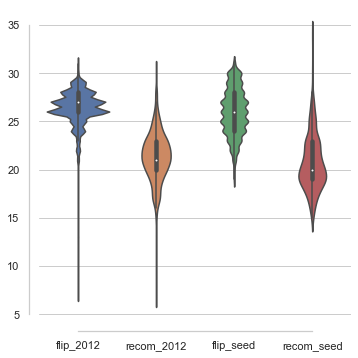

In [88]:
sns.catplot(data= df_county_split[["flip_2012",
                                     "recom_2012",
                                     "flip_seed",
                                     "recom_seed"]],
               kind="violin")

sns.despine(offset=10, trim=True)

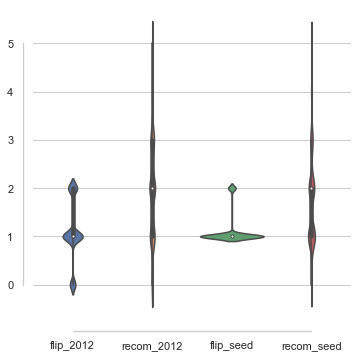

In [76]:
sns.catplot(data= df_comp_dist[["flip_2012",
                                   "recom_2012",
                                   "flip_seed",
                                   "recom_seed"]],
           kind="violin")

sns.despine(offset=10, trim=True)

(array([ 66.,   0., 308.,   0., 374.,   0., 234.,   0.,  17.,   1.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

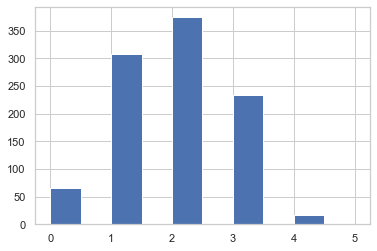

In [91]:
plt.hist(per_chain["recom_2012"]["comp_dist"])

(array([ 22.,   0., 438.,   0., 353.,   0., 144.,   0.,  40.,   3.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

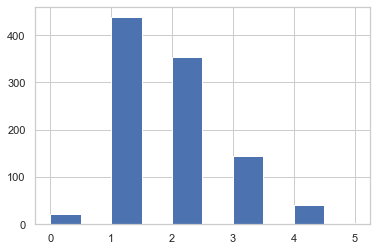

In [92]:
plt.hist(per_chain["recom_seed"]["comp_dist"])

# Constraints

*Decision Point*: Which contraints are most important in your state?

What does it mean to keep counties intact? The 2012 enacted plan was able to draw Congressional districts that kept 89% of Colorado's counties intact (i.e., only 7 counties were split out of a total of 64 counties)

In [ ]:
popbound = constraints.within_percent_of_ideal_population(partition_seed, 0.01)

In [ ]:
compactness_bound = constraints.UpperBound(
    lambda p: len(p["cut_edges"]), 1.5 * len(partition_seed["cut_edges"])
)

# Acceptance Functions

*Decision Point*: Which acceptance functions will you prioritize

*Process*: There are multiple ways to define political competitive, and the literature is not united on the best way to capture electoral competition. Indeed, there are many complicated factors that contribute to what makes an election competitive: candidate spending, incumbency effect, as well as district boundaries.

In [164]:
def competitive_county_accept(partition):
    new_score = 0 
    old_score = 0 
    for i in range(7):
        if .45 < partition.parent['USH18'].percents("First")[i] <.55:
            old_score += 1
            
        if .45 < partition['USH18'].percents("First")[i] <.55:
            new_score += 1
            
    if (new_score >= old_score) and (partition["count_splits"] < partition.parent["count_splits"]):
        return True
    elif (new_score >= old_score) and (random.random() < .15):
        return True
    elif (partition["count_splits"] < partition.parent["count_splits"]) and (random.random() < .15): 
        return True
    else:
        return False
    
def competitive_squeeze_accept(partition): 
    
    if ((min(partition["USH18"].percents("First"))) > (min(partition.parent["USH18"].percents("First")))) \
        or ((max(partition["USH18"].percents("First"))) < (max(partition.parent["USH18"].percents("First")))): 
        return True
    elif random.random() < .15:
        return True
    else:
        return False

In [167]:
acc_steps_num = 1000

acc_chain_squeeze_2012 = MarkovChain(
    proposal=recom_proposal,
    constraints=[
        popbound,
        compactness_bound
    ],
    accept=competitive_squeeze_accept, 
    initial_state=plan_2012,
    total_steps=acc_steps_num
)

acc_chain_squeeze_seed = MarkovChain(
    proposal=recom_proposal,
    constraints=[
        popbound,
        compactness_bound
    ],
    accept=competitive_squeeze_accept, 
    initial_state=partition_set_seed,
    total_steps=acc_steps_num
)

acc_chain_compcounty_2012 = MarkovChain(
    proposal=recom_proposal,
    constraints=[
        popbound,
        compactness_bound
    ],
    accept=competitive_county_accept, 
    initial_state=plan_2012,
    total_steps=acc_steps_num
)

acc_chain_compcounty_seed = MarkovChain(
    proposal=recom_proposal,
    constraints=[
        popbound,
        compactness_bound
    ],
    accept=competitive_county_accept, 
    initial_state=partition_set_seed,
    total_steps=acc_steps_num
)

In [168]:
acc_dict = {'squeeze_2012': acc_chain_squeeze_2012,
            'squeeze_seed': acc_chain_squeeze_seed,
            'compcounty_2012': acc_chain_compcounty_2012,
            'compcounty_seed': acc_chain_compcounty_seed
}

acc_per_chain = {acc_chain_name: {} for acc_chain_name in acc_dict.keys()}

for name, chain in acc_dict.items():
    print(name)
    acc_range=[]
    acc_comp=[]
    for part in chain:
        acc_range.append(part["USH18"].percents("First"))
        acc_comp.append(sum([.45<x<.55 for x in part['USH18'].percents('First')]))
    acc_per_chain[name]['range'] = np.array(acc_range)
    acc_per_chain[name]['comp_dist'] = np.array(acc_comp)

squeeze_2012
squeeze_seed
compcounty_2012
compcounty_seed


In [169]:
acc_keys = list(acc_per_chain.keys())

#df_squeeze = pd.DataFrame(columns=acc_keys)
df_comp_dist = pd.DataFrame(columns=acc_keys)

for n in range(4):
    #df_squeeze[acc_keys[n]] = pd.Series(acc_per_chain[acc_keys[n]]["squeeze"])
    df_comp_dist[acc_keys[n]] = pd.Series(acc_per_chain[acc_keys[n]]["comp_dist"])

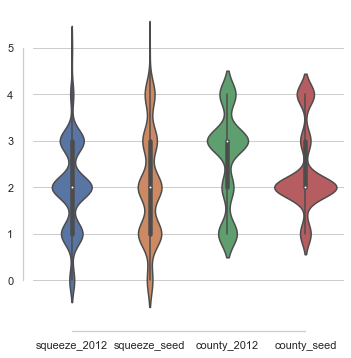

In [184]:
sns.set_theme(style="whitegrid")
acc = sns.catplot(data= df_comp_dist[["squeeze_2012",
                                "squeeze_seed",
                                "compcounty_2012",
                                "compcounty_seed"]],
            kind="violin")
acc.set_xticklabels(['squeeze_2012','squeeze_seed','county_2012','county_seed'])
acc.despine(offset=10, trim=True)

# Number of Steps

*Decision Point* Did the chain reach convergence?